In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

Using TensorFlow backend.


In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [3]:
# Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian DCTR Example.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

We then sample from normal distributions with this $\mu$ value

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [4]:
# Either load or train DCTR

def get_dctr(load=False, n_data_points=10**6, mu_min=-2, mu_max=2):
    if load:
        json_file = open('1d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("1d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:
        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

        X0 = [(np.random.normal(0, 1), mu)
              for mu in mu_values]  # Note the zero in normal(0, 1)
        X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((2, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping],
                       verbose=0)
        print("Trained DCTR Model")

    return dctr_model

### Loading Model

In [5]:
mu_min = -2
mu_max = 2

dctr_model = get_dctr(n_data_points = 10**7, mu_min=mu_min, mu_max=mu_max)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model


### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [6]:
# from NN (DCTR)
def reweight(events, param):
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param):
    mu0 = 0.0
    weights = K.exp(-(0.5 * (events - param)**2) + (0.5 * (events - mu0)**2))
    return weights

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [7]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
epsilon = sigma / 2  # Smearing width

theta0_T = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta0_T])  # Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis=1)

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta1_T])  # Detector smearing
theta1 = np.stack([theta1_T, theta1_D], axis=1)

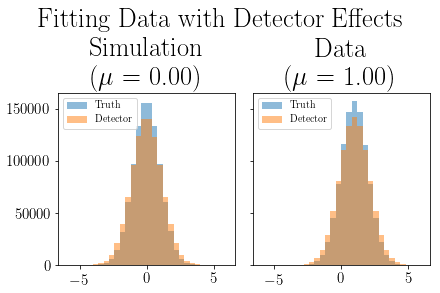

In [8]:

bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')

# fig.savefig("GaussianAltFit-1D-Fitting-Data-with-Detector-Effects.png")
plt.show()

In [9]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, 0]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
X_train_theta[:, 0][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                               axis=1)
X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.stack(
    [y_train_theta, X_train_theta[:, 0]], axis=1)

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [10]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas = np.linspace(-2, 2, 21)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


#### Redefining Reweighting Function
Adding an artificial scale factor for the weights that depends on theta. 

In [11]:
# from NN (DCTR)
def reweight(events, param):
    scale = 1. + param * 0.2
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = scale*(f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

### Truth Level Scan

In [12]:
def my_loss_wrapper_T(inputs,
                      val=0.,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = val

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [13]:
lvals_T = []
vlvals_T = []
AUC = []

for theta in thetas:
    print("Testing theta = ", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T += [min_lval]
    vlvals_T += [min_vlval]
    
    weights = reweight(tf.convert_to_tensor(xvals[:,:1][yvals==0], dtype=tf.float32), theta)
    weights = K.eval(weights)

    weights_AUC = np.ones_like(xvals[:,:1])

    weights_AUC[yvals==0] = weights
    weights_AUC = np.squeeze(weights_AUC)

    auc = roc_auc_score(yvals, model.predict(xvals[:,:1]), sample_weight = weights_AUC)
    AUC += [auc]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_T)

Testing theta =  -2.0
loss:  0.12630001270025967
val_loss:  0.12589048013836146


Testing theta =  -1.8
loss:  0.15417362776398658
val_loss:  0.15375598803162574


Testing theta =  -1.6
loss:  0.1866270977705717
val_loss:  0.18627461333572864


Testing theta =  -1.4
loss:  0.22384678727388382
val_loss:  0.22353834930062294


Testing theta =  -1.2
loss:  0.26613706958293915
val_loss:  0.2658561718016863


Testing theta =  -1.0
loss:  0.3133193426132202
val_loss:  0.313130979090929


Testing theta =  -0.7999999999999998
loss:  0.365142913877964
val_loss:  0.3649761688113213


Testing theta =  -0.5999999999999999
loss:  0.4167855796515942
val_loss:  0.4166313208341598


Testing theta =  -0.3999999999999999
loss:  0.47083049529790877
val_loss:  0.4706722595691681


Testing theta =  -0.19999999999999996
loss:  0.5278324750959873
val_loss:  0.5276718156635761


Testing theta =  0.0
loss:  0.584670316696167
val_loss:  0.5844163308739663


Testing theta =  0.20000000000000018
loss:  0.63361488

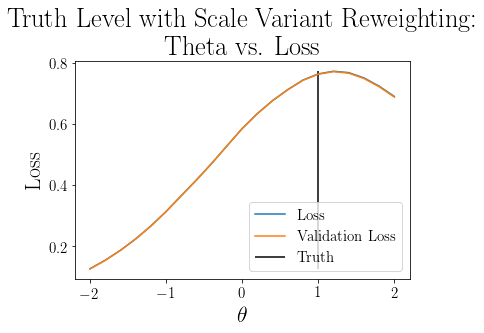

In [27]:
plt.title("Truth Level with Scale Variant Reweighting:\nTheta vs. Loss")
plt.plot(thetas, lvals_T, label='Loss')
plt.plot(thetas, vlvals_T, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T),
           ymax=np.max(lvals_T),
           label='Truth')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-AUCvsLoss-Truth-Level-with-Scale-Variant-Reweighting:\nTheta-vs-Loss.png"
# )
plt.show()

We can see adding scale variant reweighting has shifted the maximum loss away from the Truth value.

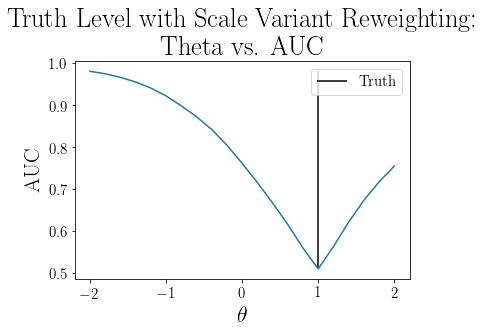

In [22]:
plt.title("Truth Level with Scale Variant Reweighting:\nTheta vs. AUC")
plt.plot(thetas, AUC)
plt.xlabel(r'$\theta$')
plt.ylabel('AUC')
plt.vlines(theta1_param,
           ymin=np.min(AUC),
           ymax=np.max(AUC),
           label='Truth')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-AUCvsLoss-Truth-Level-with-Scale-Variant-Reweighting:\nTheta-vs-AUC.png"
# )
plt.show()

Despite the weights not being normalized, we see that AUC still has the correct minimum at truth!

Let's return the reweighting function to its original definition (remove the artificial scale factor) and see if there is some inherent scale variance on theta.

In [16]:
# from NN (DCTR)
def reweight(events, param):
    scale = 1.
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = scale*(f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param):
    mu0 = 0.0
    weights = K.exp(-(0.5 * (events - param)**2) + (0.5 * (events - mu0)**2))
    return weights

In [17]:
lvals_T2 = []
vlvals_T2 = []
AUC2 = []
thetas = np.linspace(0.9, 1.1, 21)
for theta in thetas:
    print("Testing theta = ", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T2 += [min_lval]
    vlvals_T2 += [min_vlval]
    
    weights = reweight(tf.convert_to_tensor(xvals[:,:1][yvals==0], dtype=tf.float32), theta)
    weights = K.eval(weights)

    weights_AUC = np.ones_like(xvals[:,:1])

    weights_AUC[yvals==0] = weights
    weights_AUC = np.squeeze(weights_AUC)

    auc = roc_auc_score(yvals, model.predict(xvals[:,:1]), sample_weight = weights_AUC)
    AUC2 += [auc]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_T)

Testing theta =  0.9
loss:  0.6958719075918197
val_loss:  0.6949382256865502


Testing theta =  0.91
loss:  0.6961600109934807
val_loss:  0.6952672189474106


Testing theta =  0.92
loss:  0.6964296223521232
val_loss:  0.6955665510892868


Testing theta =  0.93
loss:  0.6967365245819092
val_loss:  0.6958571744561195


Testing theta =  0.9400000000000001
loss:  0.6969956400394439
val_loss:  0.6961142214536666


Testing theta =  0.9500000000000001
loss:  0.6972514412403107
val_loss:  0.6963643789887428


Testing theta =  0.9600000000000001
loss:  0.6974719421863556
val_loss:  0.6965772769451142


Testing theta =  0.9700000000000001
loss:  0.6976760603785515
val_loss:  0.6967686389684677


Testing theta =  0.9800000000000001
loss:  0.6978560668230057
val_loss:  0.6969422048926354


Testing theta =  0.9900000000000001
loss:  0.6980214114785195
val_loss:  0.6970949400663375


Testing theta =  1.0
loss:  0.6981417775154114
val_loss:  0.6972244018316269


Testing theta =  1.01
loss:  0.6982838

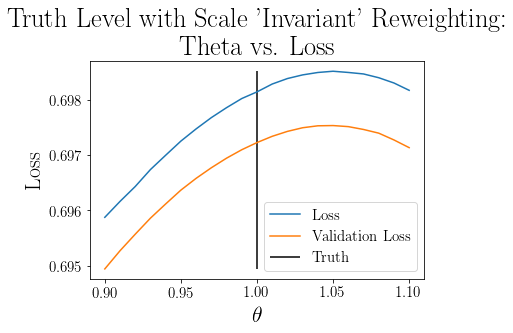

In [25]:
plt.title("Truth Level with Scale 'Invariant' Reweighting:\nTheta vs. Loss")
plt.plot(thetas, lvals_T2, label='Loss')
plt.plot(thetas, vlvals_T2, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T2+ vlvals_T2),
           ymax=np.max(lvals_T2 + vlvals_T2),
           label='Truth')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-AUCvsLoss-Truth-Level-with-Scale-Invariant-Reweighting:\nTheta-vs-Loss.png"
# )
plt.show()

Zooming into a finer window for theta, we see that there is some bias in the scale of the weights that depends on theta.

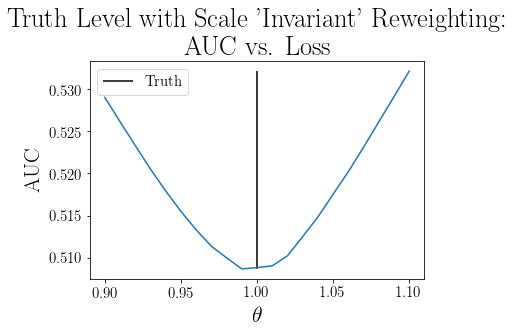

In [24]:
plt.title("Truth Level with Scale 'Invariant' Reweighting:\nAUC vs. Loss")
plt.plot(thetas, AUC2)
plt.xlabel(r'$\theta$')
plt.ylabel('AUC')
plt.vlines(theta1_param,
           ymin=np.min(AUC2),
           ymax=np.max(AUC2),
           label='Truth')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-AUCvsLoss-Truth-Level-with-Scale-Invariant-Reweighting:\nTheta-vs-AUC.png"
# )
plt.show()

Again, however, we see AUC matches truth much better than simply loss.